In [82]:
#!pip install matplotlib
#!pip install numpy
#!pip install pandas 
#!pip install pykml
#!pip install pyshp

In [83]:
import pandas as pd
from pykml.factory import KML_ElementMaker as KML
from lxml import etree
import shapefile as shp
import matplotlib.pyplot as plt
import numpy as np

In [84]:
file_name = 'relatorios/relatorio_380.csv'

In [85]:
df = pd.read_csv(filepath_or_buffer=file_name, sep=';', encoding= 'unicode_escape')

In [86]:
filtro_intervencao = df['Tipo de Intervenção'] == 'Cadastro apenas da barragem'
filtro_status1 = df['Status'] != 'Concluído'
filtro_status2 = df['Status'] != 'Desativado'
filtro_status3 = df['Status'] != 'Em andamento'

In [87]:
df_filtrado = df[filtro_status1 & filtro_status2 & filtro_status3 & filtro_intervencao]

In [88]:
df_filtrado.shape

(89, 25)

In [89]:
df_filtrado.head()

,Número do cadastro,Número da portaria,Nome do usuário de água,Natureza da intervenção,Tipo da Fonte de Captação,Tipo de Intervenção,Classificação,Status,Observação,Data de início do cadastro,...,Finalidades de Uso,Bacia Hidrográfica,Corpo Hídrico,Sistema Aquífero,Município,Nome da Geometria,Latitude,Longitude,Latitude (ponto final),Longitude (ponto final)
1,2020/005.099,O-000.870/2020,BT GERADORA DE ENERGIA ELETRICA S.A.,Água Superficial,Barragem de nível,Cadastro apenas da barragem,Outorga,Concedida,-,27/03/2020,...,Aproveitamento hidrelétrico,Bacia Hidrográfica do Rio da Várzea,Rio Guarita,-,Erval Seco,Ponto 1,"-53,5789","-27,5612",-,-
7,2020/002.866,-,LINHA ONZE OESTE ENERGIA LTDA,Água Superficial,Barragem de nível,Cadastro apenas da barragem,Cadastro,Aguardando formalização de documentos,-,19/02/2020,...,Aproveitamento hidrelétrico,Bacia Hidrográfica do Rio Ijuí,Rio Ijuí,-,Coronel Barros,Ponto 1,"-54,0045500199785","-28,3511124417778",-,-
8,2020/002.683,-,Cooperativa de Geração de Energia e Desenvolvi...,Água Superficial,Barragem de nível,Cadastro apenas da barragem,Cadastro,Aguardando formalização de documentos,-,17/02/2020,...,Aproveitamento hidrelétrico,Bacia Hidrográfica dos Rios Turvo - Santa Rosa...,Rio Buricá,-,Chiapetta,Ponto 1,"-53,9701307613505","-27,9612491935233",-,-
12,2020/001.754,-,BORTOLON AGROCOMERCIAL EIRELI,Água Superficial,Barragem de acumulação,Cadastro apenas da barragem,Cadastro,Aguardando análise,-,31/01/2020,...,Aproveitamento hidrelétrico,Bacia Hidrográfica dos Rios Apuaê - Inhandava,Rio Socorro,-,Vacaria,Ponto 1,"-50,8559701377817","-28,2990821433521",-,-
13,2020/001.523,R-000.836/2020,ENERBIO SERVICOS DE ENGENHARIA LTDA,Água Superficial,Barragem de nível,Cadastro apenas da barragem,Reserva de disponibilidade hídrica,Concedida,-,28/01/2020,...,Aproveitamento hidrelétrico,Bacia Hidrográfica do Rio da Várzea,Rio Fortaleza,-,Erval Seco,Ponto 1,"-53,5472","-27,4186",-,-


In [90]:
df_filtrado['Status'].unique()

array(['Concedida', 'Aguardando formalização de documentos',
       'Aguardando análise',
       'Aguardando alterações de dados inconsistentes', 'Indeferida',
       'Em análise', 'Aguardando pagamento da guia'], dtype=object)

In [91]:
df_nomes = df_filtrado[['Número do cadastro', 'Número da portaria', 'Nome do usuário de água', 'Status', 'Data de saída do processo', 'Município']]

In [92]:
df_nomes['Nome'] = 'N/D'

In [93]:
nomes = pd.read_csv("nomes.csv", sep=",", encoding='utf8')

In [94]:
nomes.head()

,Número do cadastro,Número da portaria,Nome do usuário de água,Nome
0,2020/005.099,O-000.870/2020,BT GERADORA DE ENERGIA ELETRICA S.A.,PCH Ferradura
1,2020/002.866,-,LINHA ONZE OESTE ENERGIA LTDA,PCH Linha Onze Oeste
2,2020/002.683,-,Cooperativa de Geração de Energia e Desenvolvi...,CGH Nilo Bonfanti
3,2020/001.754,-,BORTOLON AGROCOMERCIAL EIRELI,CGH Três Marias
4,2020/001.523,R-000.836/2020,ENERBIO SERVICOS DE ENGENHARIA LTDA,CGH Fortaleza


In [95]:
for index, row in nomes.iterrows():
    num = row['Número do cadastro']
    name = row['Nome']
    for index1, row1 in df_nomes.iterrows():
        num1 = row1['Número do cadastro']
        if num == num1:
            df_nomes.loc[index1, 'Nome'] = name

In [96]:
df_nomes.head()

,Número do cadastro,Número da portaria,Nome do usuário de água,Status,Data de saída do processo,Município,Nome
1,2020/005.099,O-000.870/2020,BT GERADORA DE ENERGIA ELETRICA S.A.,Concedida,24/04/2020,Erval Seco,PCH Ferradura
7,2020/002.866,-,LINHA ONZE OESTE ENERGIA LTDA,Aguardando formalização de documentos,19/02/2020,Coronel Barros,PCH Linha Onze Oeste
8,2020/002.683,-,Cooperativa de Geração de Energia e Desenvolvi...,Aguardando formalização de documentos,05/03/2020,Chiapetta,CGH Nilo Bonfanti
12,2020/001.754,-,BORTOLON AGROCOMERCIAL EIRELI,Aguardando análise,06/04/2020,Vacaria,CGH Três Marias
13,2020/001.523,R-000.836/2020,ENERBIO SERVICOS DE ENGENHARIA LTDA,Concedida,09/04/2020,Erval Seco,CGH Fortaleza


In [97]:
df_filtrado['Nome'] = df_nomes['Nome']

In [98]:
df_nomes.to_csv('nomes_dumped.csv', index=False)

In [99]:
aguardando = df_filtrado[df_filtrado['Status'] == 'Aguardando análise'][['Número do cadastro', 'Nome do usuário de água', 'Data de início do cadastro', 'Data de saída do processo']]
aguardando['Data de saída do processo'] = pd.to_datetime(aguardando['Data de saída do processo'], dayfirst=True)
aguardando['Data de início do cadastro'] = pd.to_datetime(aguardando['Data de início do cadastro'], dayfirst=True)
aguardando.sort_values('Data de saída do processo')
aguardando.to_csv('aguardando_analise.csv', index=False)
aguardando

,Número do cadastro,Nome do usuário de água,Data de início do cadastro,Data de saída do processo
12,2020/001.754,BORTOLON AGROCOMERCIAL EIRELI,2020-01-31,2020-04-06
96,2019/004.975,PALOMA ENERGIA LTDA,2019-03-29,2020-04-23


In [100]:
aguardando = df_filtrado[df_filtrado['Status'] == 'Em análise'][['Número do cadastro', 'Nome do usuário de água', 'Data de início do cadastro', 'Data de saída do processo']]
aguardando['Data de saída do processo'] = pd.to_datetime(aguardando['Data de saída do processo'], dayfirst=True)
aguardando['Data de início do cadastro'] = pd.to_datetime(aguardando['Data de início do cadastro'], dayfirst=True)
aguardando.sort_values('Data de saída do processo')
aguardando.to_csv('em_analise.csv', index=False)
aguardando

,Número do cadastro,Nome do usuário de água,Data de início do cadastro,Data de saída do processo
103,2019/003.312,TOUROS III ENERGÉTICA S.A.,2019-02-27,2020-02-20
108,2019/002.931,TOUROS II ENERGÉTICA S.A.,2019-02-22,2020-01-31
121,2019/001.316,OLFAR S/A ALIMENTO E ENERGIA,2019-01-25,2020-04-16
144,2018/033.376,Agropecuaria Fockink Ltda,2018-11-29,2020-01-07


In [101]:
shp_path = "estados_2010.shp"
sf = shp.Reader(shp_path)

In [102]:
sf.records()[22]

Record #22: [23, 'Rio Grande do Sul', 'RS', '1', '43']

In [103]:
def plot_shape(idt, ax, sf):
    shape_ex = sf.shape(idt)
    x_lon = np.zeros((len(shape_ex.points),1))
    y_lat = np.zeros((len(shape_ex.points),1))
    for ip in range(len(shape_ex.points)):
        x_lon[ip] = shape_ex.points[ip][0]
        y_lat[ip] = shape_ex.points[ip][1]
    ax.plot(x_lon,y_lat,c='gray') 
    x0 = np.mean(x_lon)
    y0 = np.mean(y_lat)

In [104]:
pie_dict = {}
for s in df_filtrado['Status'].unique():
    ns = sum(df_filtrado['Status'] == s)
    pie_dict[s] = ns

In [105]:
def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return '{p:.2f}%  ({v:d})'.format(p=pct,v=val)
    return my_autopct

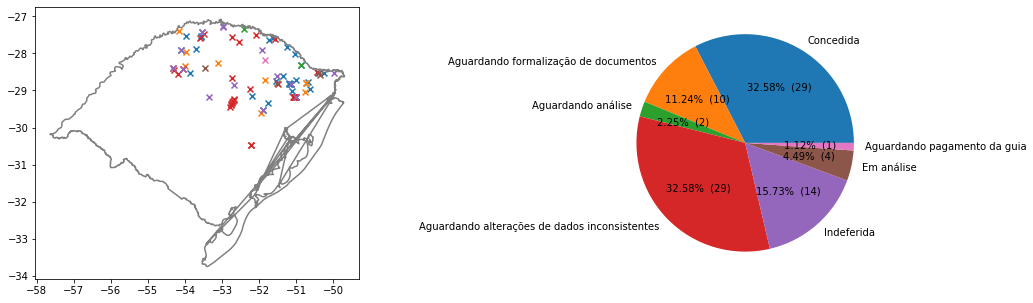

In [106]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18,5))
ax2.pie(pie_dict.values(), autopct=make_autopct(pie_dict.values()), labels=pie_dict.keys())
plot_shape(22, ax1, sf)
for s in df_filtrado['Status'].unique():
    f = df_filtrado['Status'] == s
    x, y = df_filtrado[f]['Latitude'].values, df_filtrado[f]['Longitude'].values
    x, y = [float(i.replace(',','.')) for i in x], [float(i.replace(',','.')) for i in y]
    ax1.scatter(x, y, label = s, marker='x')
ax1.axis('scaled')
#fig.suptitle('Status dos processos de hidrelétricas do SIOUT')
#ax2.legend(loc='upper right')
plt.savefig('Status', bbox_inches='tight')

In [107]:
doc = KML.Document()

In [108]:
icons = {
    'verde':'http://maps.google.com/mapfiles/kml/pushpin/grn-pushpin.png',
    'amarelo':'http://maps.google.com/mapfiles/kml/pushpin/ylw-pushpin.png',
    'vermelho':'http://maps.google.com/mapfiles/kml/pushpin/red-pushpin.png'
}

In [109]:
for color in icons:
    
    s = KML.Style(
            KML.IconStyle(
                KML.scale(1.2),
                KML.Icon(
                    KML.href(icons[color])
                ),
            ),
            id=color,
        )
    
    doc.append(s)

In [110]:
fld_ag_doc = KML.Folder(KML.name('Aguardando formalização de documentos'))
fld_ag_an = KML.Folder(KML.name('Aguardando análise'))
fld_ag_alt = KML.Folder(KML.name('Aguardando alterações de dados inconsistentes'))
fld_an = KML.Folder(KML.name('Em análise'))
fld_conc = KML.Folder(KML.name('Concedida'))
fld_ind = KML.Folder(KML.name('Indeferida'))

In [111]:
for index, row in df_filtrado.iterrows():
    nome=row['Nome']
    name = row['Número do cadastro']
    usuario = row['Nome do usuário de água']
    status = row['Status']
    corpo_hidrico = row['Corpo Hídrico']
    municipio = row['Município']
    description = '''
Processo: {}
Usuario: {}
Status: {}
Municipio: {}
Corpo Hidrico: {}
    '''.format(name, usuario, status, municipio, corpo_hidrico)
    lat = row['Latitude'].replace(',','.')
    long = row['Longitude'].replace(',','.')
    coordinates = lat+','+long
    
    if status == 'Concedida':
        style = '#verde'
    elif status == 'Indeferida':
        style = '#vermelho'
    else:
        style = '#amarelo'
    
    p = KML.Placemark(
        KML.name(nome),
        KML.Point(KML.coordinates(coordinates)),
        KML.description(description),
        KML.styleUrl(style))
    
    if status == 'Aguardando formalização de documentos':
        fld_ag_doc.append(p)
    elif status == 'Aguardando análise':
        fld_ag_an.append(p)
    elif status == 'Aguardando alterações de dados inconsistentes':
        fld_ag_alt.append(p)
    elif status == 'Em análise':
        fld_an.append(p)
    elif status == 'Concedida':
        fld_conc.append(p)
    elif status == 'Indeferida':
        fld_ind.append(p)

In [112]:
doc.append(fld_ag_doc)
doc.append(fld_ag_an)
doc.append(fld_ag_alt)
doc.append(fld_an)
doc.append(fld_conc)
doc.append(fld_ind)

In [113]:
kml_file_path = 'hidreletricas_SIOUT.kml'

In [114]:
kml_str = etree.tostring(doc, pretty_print=True).decode('utf-8')

In [115]:
f = open(kml_file_path, "w")
f.write(kml_str)
f.close()